**Load python libraries**

In [1]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import os.path
import xarray as xr
import pandas as pd
import numpy as np
import requests
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from IPython.display import Image, display
from dask.distributed import Client, progress
from glob import glob
import colorsys
from matplotlib.colors import LinearSegmentedColormap # Linear interpolation for color maps
import pylab as pl
from shapely.geometry import Point
from descartes import PolygonPatch

from modules.GOESR_functions import goes_lat_lon_reproj
from modules.concave_hull import alpha_shape, plot_polygon

#### Load Lightning Data

In [2]:
### Lightning Data
filename = '/home/sbarc/students/nash/data/ENTLN/ENTLN_flashes_-_UC_Santa_Barbara_030419_00UTC_to_030819_00UTC_flash_combined.csv'
df = pd.read_csv(filename, header=0, parse_dates=['timestamp'])
df['day'] = df.timestamp.dt.day ## Make a column that shows just the day of the lightning strike
df['hour'] = df.timestamp.dt.hour ## Make a column that shows just the day of the lightning strike
df['freq'] = df.icmultiplicity + df.cgmultiplicity

In [3]:
alpha = 1.1
concave_hull = []

days_less = ['05', '05', '05', '05', '06', '06', '06', '06', '07']
days_greater = ['04', '05', '05', '05', '05', '06', '06', '06', '06']
hours_less = ['00', '06', '12', '18', '00', '06', '12', '18', '00']
hours_greater = ['18', '00', '06', '12', '18', '00','06', '12', '18']
for i in np.arange(9):
    mask = (df['timestamp'] < '2019-03-{0}-{1}'.format(days_less[i], hours_less[i])) & (df['timestamp'] >= '2019-03-{0}-{1}'.format(days_greater[i], hours_greater[i]))
#     points_lat.append(df.latitude[mask])            
#     points_lon.append(df.longitude[mask])
    x, y = df.longitude[mask], df.latitude[mask]
    points = list(zip(x, y))
    new_points = [Point(point) for point in points] ## Shapely Point Object
    concave_hull.append(alpha_shape(new_points, alpha=alpha))

#### Load GOES-R Cloud Top Height Data

In [4]:
filename_pattern = '/home/sbarc/students/nash/data/GOES17_ABI_L2_ACHAC/6-hours/OR_ABI-L2-AC*.nc'

GOES_files = glob(filename_pattern) # search files 
GOES_files.sort()
DS = xr.open_mfdataset(GOES_files, concat_dim='t')
# DS.info()

**Convert radiance scan x, y data into derived latitude and longitude values using [this tutorial](https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm).**

In [5]:
lats, lons = goes_lat_lon_reproj(DS)
# print test coordinates
print('{} N, {} W'.format(lats[200,300],abs(lons[200,300])))

24.48737335205078 N, 131.9049530029297 W


In [6]:
# put reprojected GOES HT data into new dataset
DS_goes = xr.Dataset({'HT': (['time', 'y', 'x'], DS.HT.values)},
                     coords={'time': DS.t.values,
                            'lat': (['y', 'x'], lats),
                            'lon': (['y', 'x'], lons)})
DS_goes
# lats, dims=['y', 'x'], coords={'y': lats[:,0], 'x': lats[0,:]})


<xarray.Dataset>
Dimensions:  (time: 9, x: 500, y: 300)
Coordinates:
  * time     (time) datetime64[ns] 2019-03-04T18:03:37.617556992 ... 2019-03-06T18:03:37.605403008
    lat      (y, x) float32 53.392086 53.35663 53.322685 ... 14.841187 14.843236
    lon      (y, x) float32 -184.08673 -183.76062 ... -112.57735 -112.468475
Dimensions without coordinates: x, y
Data variables:
    HT       (time, y, x) float32 nan nan nan nan ... 255.76071 233.78604 nan

#### Import CFSv2 0* Isotherm Data

In [8]:
filename_pattern =  '/home/sbarc/students/nash/data/CFSv2/netcdf_CFSv2/2019*'
ds = xr.open_mfdataset(filename_pattern, engine='netcdf4')
zero_isotherm = ds.HGT_0Cisotherm.load()
zero_isotherm.shape

(9, 361, 720)

In [9]:
## convert longitude from 0-359 to -180-179
da = zero_isotherm.assign_coords(longitude=(((zero_isotherm.longitude + 180) % 360) - 180))
da
## interpolate dataarray to same longtiude and latitude as DS_goes
dsi = da.interp(longitude=DS_goes.lon, latitude=DS_goes.lat)
dsi

## Subtract zero degree isotherm (dsi) from cloud top height (DS_goes)
## obtain cloud thickness

cloud_thick = []
for i in np.arange(9):
    cloud_thick.append(DS_goes.HT.values[i] - dsi.values[i])
    
newarray = np.dstack(cloud_thick)
newarray.shape

# put cloud thickness data into new dataset
DS_CTH = xr.Dataset({'TH': (['y', 'x', 'time'], newarray)},
                     coords={'lon': (['y', 'x'], lons),
                            'lat': (['y', 'x'], lats),
                            'time': DS.t.values})
DS_CTH = DS_CTH.transpose('time', 'y', 'x')

./figures/figS8.png


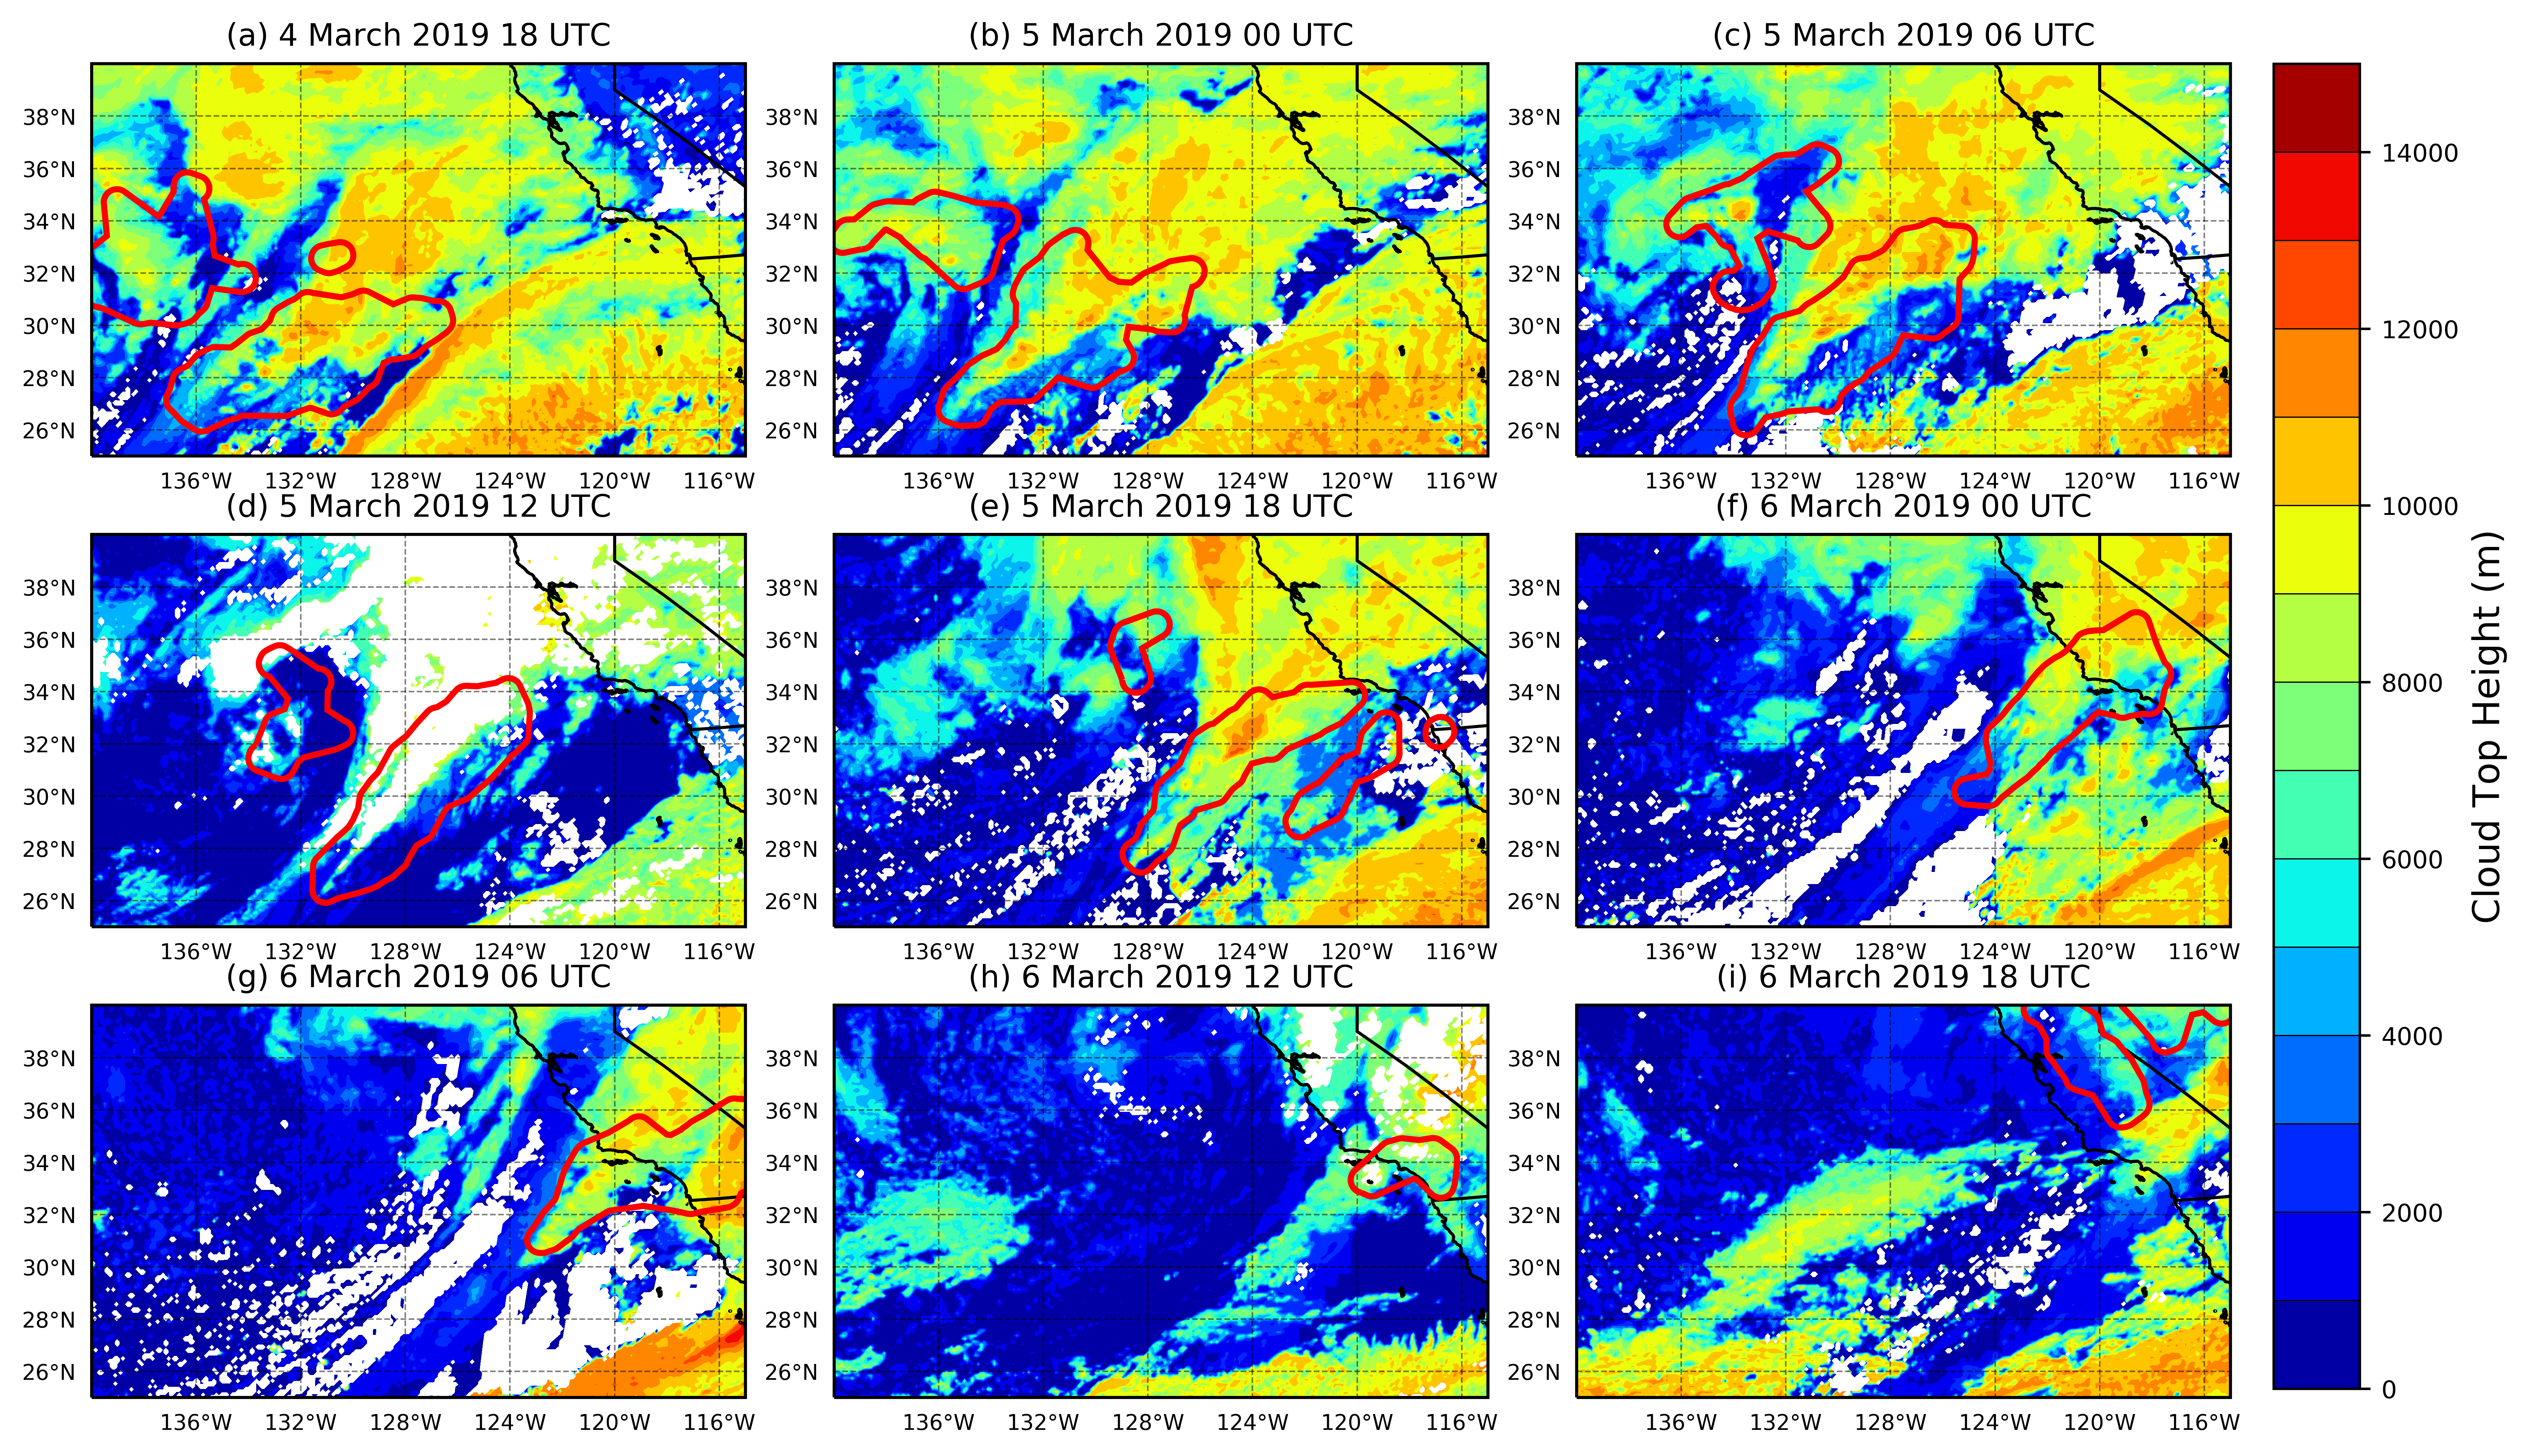

<Figure size 7800x4800 with 0 Axes>

In [13]:
fig = plt.figure(figsize=(13., 8.0))
fig.dpi = 600
fname = './figures/figS8'
fmt = 'png'
results = DS.HT

# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

subtitles = ['(a) 4 March 2019 18 UTC', 
             '(b) 5 March 2019 00 UTC', '(c) 5 March 2019 06 UTC', '(d) 5 March 2019 12 UTC',
             '(e) 5 March 2019 18 UTC',
            '(f) 6 March 2019 00 UTC', '(g) 6 March 2019 06 UTC', '(h) 6 March 2019 12 UTC',
             '(i) 6 March 2019 18 UTC']
# ext = (-138., -118.0, 24.0, 44.0)
ext = [-115.0, -140.0, 25.0, 40.0]
clevs = np.arange(0, 16000, 1000)
clevs_thick = np.arange(0, 13000, 1000)
clevs_fl = np.arange(0, 5250, 250)

for i in np.arange(len(results)):
    ax = plt.subplot(3, 3, i+1, projection=mapcrs)
    ax.set_extent(ext, crs=mapcrs)
    cf = ax.contourf(DS_goes.lon, DS_goes.lat, results[i], transform=datacrs,
                       cmap='jet', levels=clevs)
#     cf = ax.contourf(DS_CTH.lon, DS_CTH.lat, DS_CTH.TH.values[i], transform=datacrs,
#                        cmap='jet', levels=clevs_thick)
#     cf = ax.contourf(ds.longitude, ds.latitude, zero_isotherm.values[i], transform=datacrs,
#                        cmap='jet', levels=clevs_fl)
    
    ## Plot Lightning Strike Polygons for each timestep ##
#     ax.plot(points_lon[i], points_lat[i], 'k.', markersize=.5, transform=datacrs)
    hull = concave_hull[i]
    patch = PolygonPatch(hull.buffer(0.5),
                         ec='#ff0000', fill=False,
                         zorder=2, linewidth=2)
    ax.add_patch(patch)
    
    ax.coastlines(linewidths=1.0, resolution='10m')
    ax.add_feature(states_provinces, edgecolor='k')
    ax.add_feature(cfeature.BORDERS)
    ax.set_title(subtitles[i], fontsize=10)
    ## Add in meridian and parallels
    gl = ax.gridlines(crs=mapcrs, draw_labels=True,
                  linewidth=.5, color='black', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator(np.arange(-140., -110., 4))
    gl.ylocator = mticker.FixedLocator(np.arange(24, 44, 2))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 7}
    gl.ylabel_style = {'size': 7}

# # # add colorbar [left, bottom, width, height]
ax2 = fig.add_axes([0.9, 0.13, 0.03, 0.75])
cbar = fig.colorbar(cf, cax=ax2, drawedges=True, 
                    orientation='vertical', extendfrac='auto')
cbar.ax.tick_params(labelsize=8)
cbar.set_label('Cloud Top Height (m)', fontsize=12)

plt.subplots_adjust(hspace=0.2, wspace=0.003)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

./figures/figS9.png


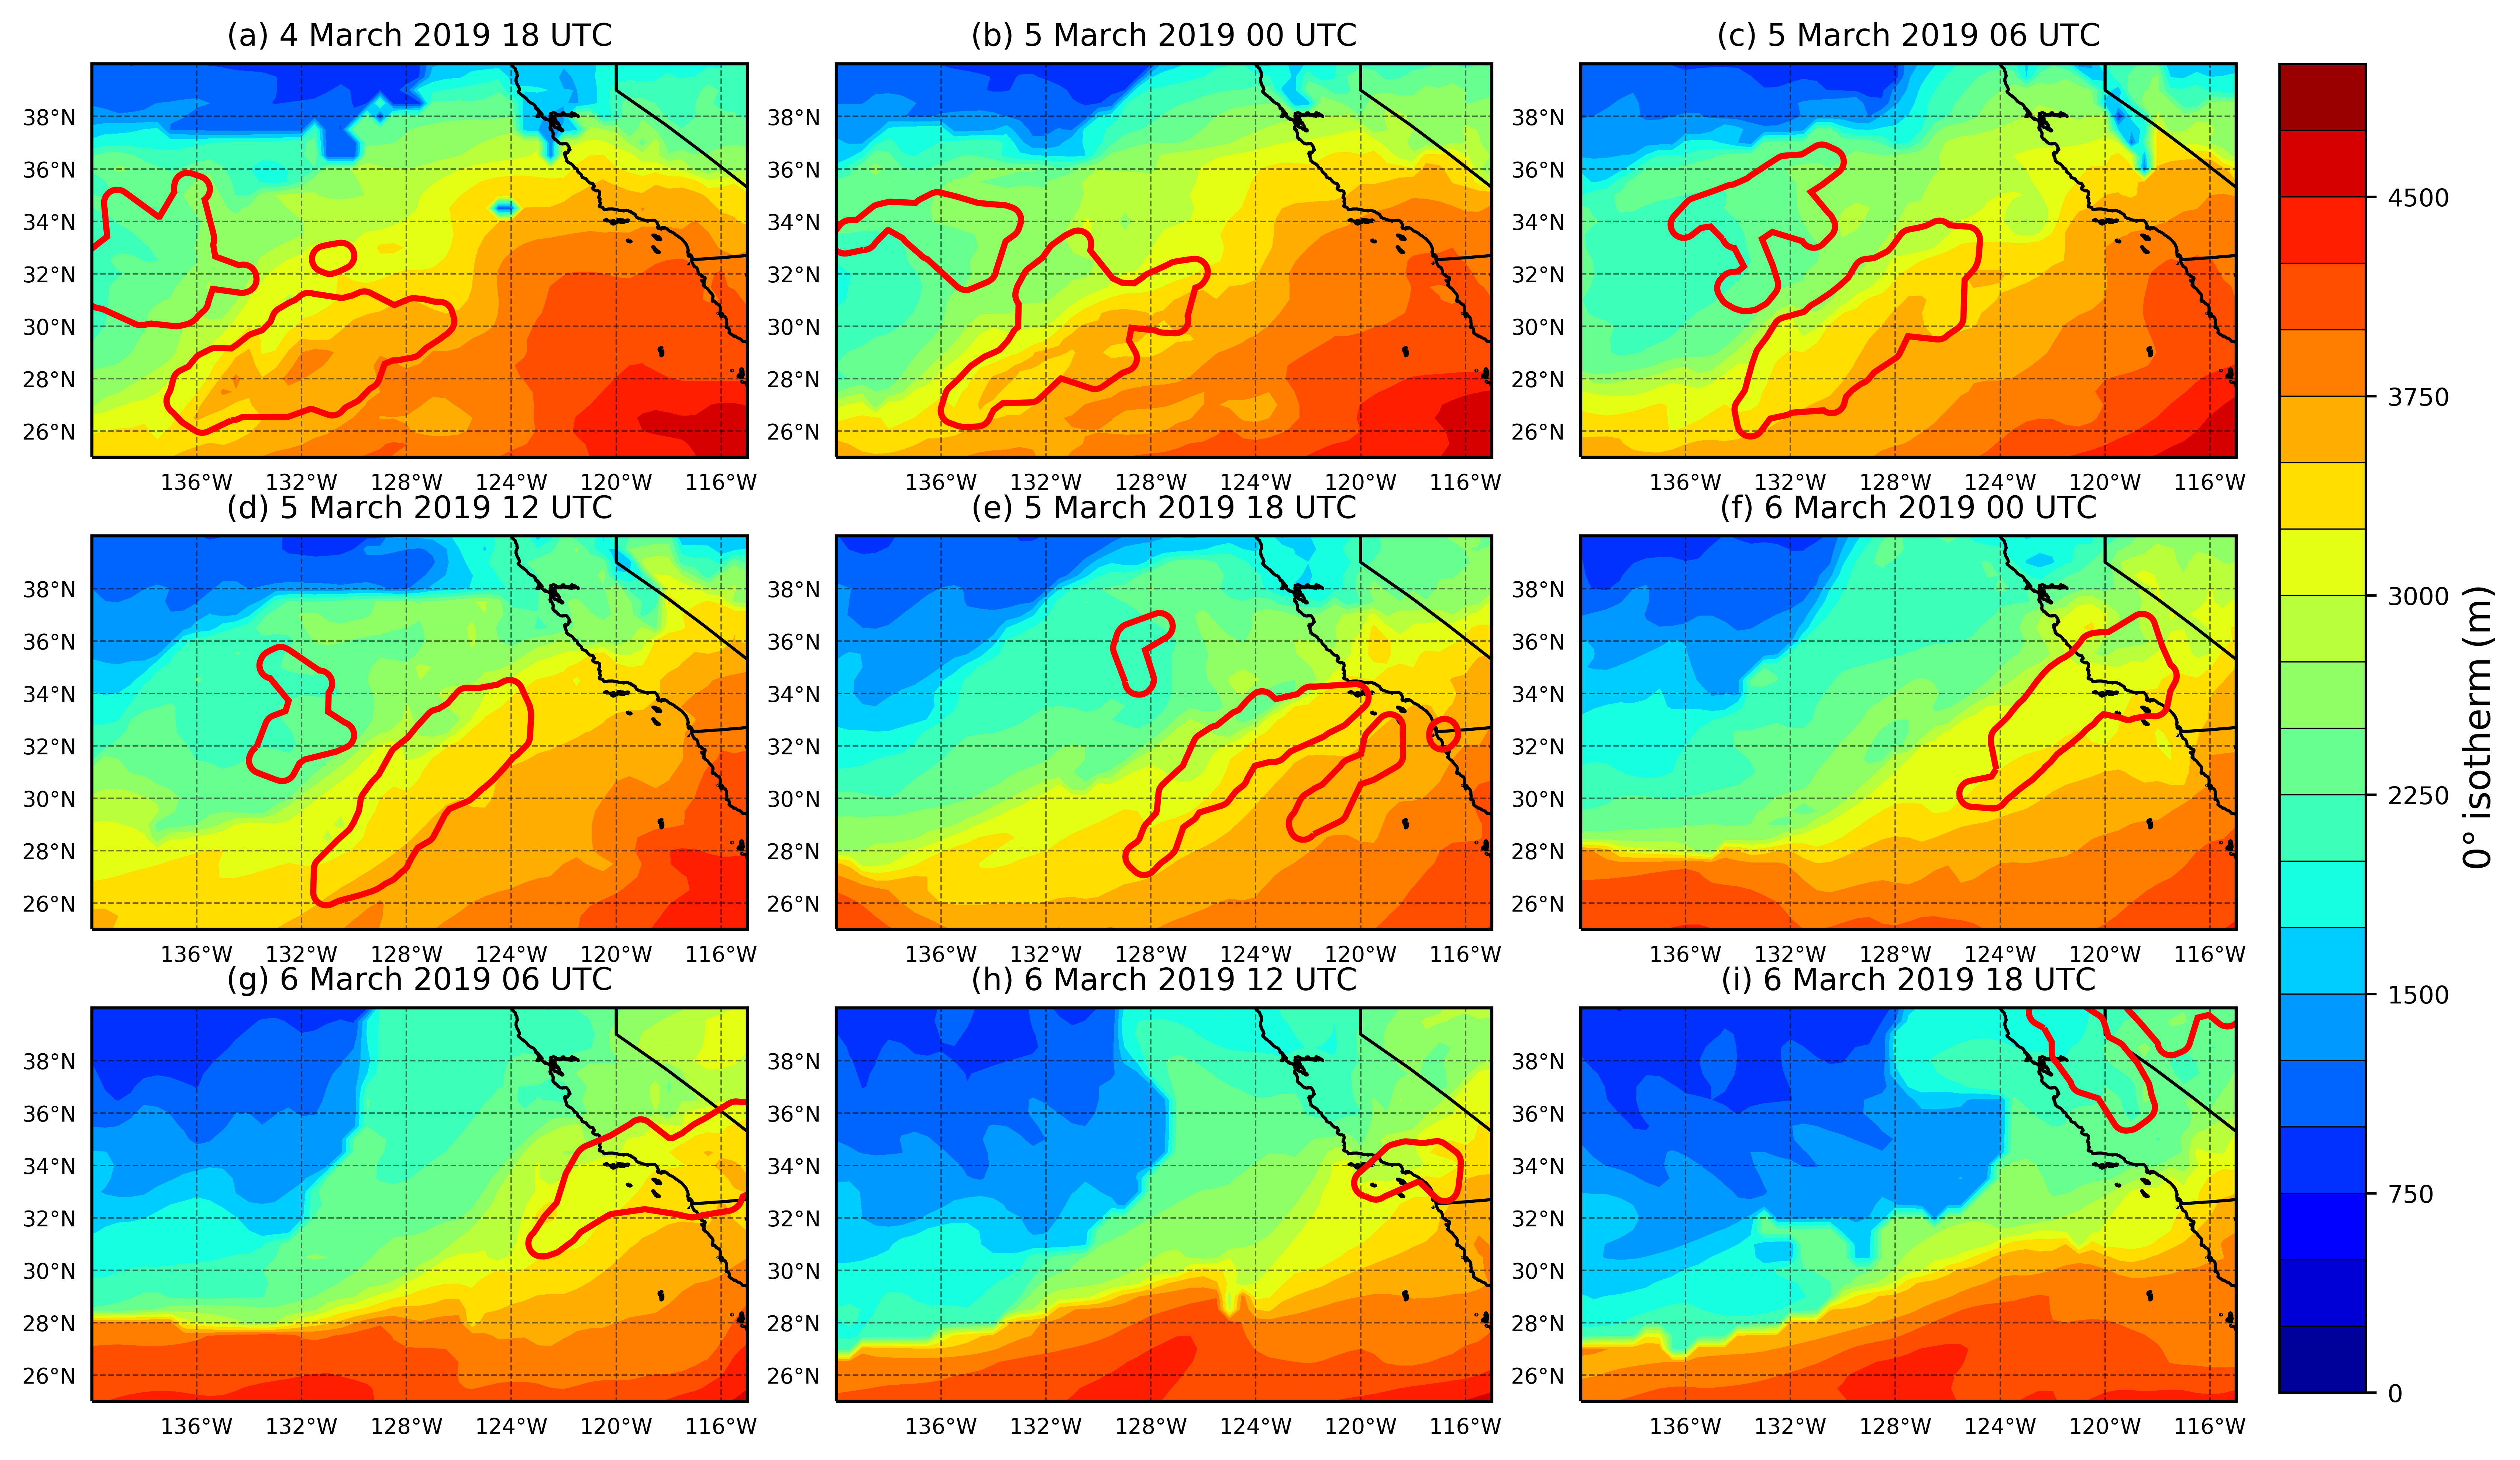

<Figure size 7800x4800 with 0 Axes>

In [14]:
fig = plt.figure(figsize=(13., 8.0))
fig.dpi = 600
fname = './figures/figS9'
fmt = 'png'
results = DS.HT

# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

subtitles = ['(a) 4 March 2019 18 UTC', 
             '(b) 5 March 2019 00 UTC', '(c) 5 March 2019 06 UTC', '(d) 5 March 2019 12 UTC',
             '(e) 5 March 2019 18 UTC',
            '(f) 6 March 2019 00 UTC', '(g) 6 March 2019 06 UTC', '(h) 6 March 2019 12 UTC',
             '(i) 6 March 2019 18 UTC']
# ext = (-138., -118.0, 24.0, 44.0)
ext = [-115.0, -140.0, 25.0, 40.0]
clevs = np.arange(0, 16000, 1000)
clevs_thick = np.arange(0, 13000, 1000)
clevs_fl = np.arange(0, 5250, 250)

for i in np.arange(len(results)):
    ax = plt.subplot(3, 3, i+1, projection=mapcrs)
    ax.set_extent(ext, crs=mapcrs)
#     cf = ax.contourf(DS_goes.lon, DS_goes.lat, results[i], transform=datacrs,
#                        cmap='jet', levels=clevs)
#     cf = ax.contourf(DS_CTH.lon, DS_CTH.lat, DS_CTH.TH.values[i], transform=datacrs,
#                        cmap='jet', levels=clevs_thick)
    cf = ax.contourf(ds.longitude, ds.latitude, zero_isotherm.values[i], transform=datacrs,
                       cmap='jet', levels=clevs_fl)
    
    ## Plot Lightning Strike Polygons for each timestep ##
#     ax.plot(points_lon[i], points_lat[i], 'k.', markersize=.5, transform=datacrs)
    hull = concave_hull[i]
    patch = PolygonPatch(hull.buffer(0.5),
                         ec='#ff0000', fill=False,
                         zorder=2, linewidth=2)
    ax.add_patch(patch)
    
    ax.coastlines(linewidths=1.0, resolution='10m')
    ax.add_feature(states_provinces, edgecolor='k')
    ax.add_feature(cfeature.BORDERS)
    ax.set_title(subtitles[i], fontsize=10)
    ## Add in meridian and parallels
    gl = ax.gridlines(crs=mapcrs, draw_labels=True,
                  linewidth=.5, color='black', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator(np.arange(-140., -110., 4))
    gl.ylocator = mticker.FixedLocator(np.arange(24, 44, 2))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 7}
    gl.ylabel_style = {'size': 7}

# # # add colorbar [left, bottom, width, height]
ax2 = fig.add_axes([0.9, 0.13, 0.03, 0.75])
cbar = fig.colorbar(cf, cax=ax2, drawedges=True, 
                    orientation='vertical', extendfrac='auto')
cbar.ax.tick_params(labelsize=8)
cbar.set_label('$\mathrm{0 \degree \: isotherm \: (m)}$', fontsize=12)

plt.subplots_adjust(hspace=0.2, wspace=0.003)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))